### Import Resources

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
print('Using:')
print('\t\u2022 TensorFlow version:', tf.__version__)
print('\t\u2022 Running on GPU' if tf.test.is_gpu_available() else '\t\u2022 GPU device not found. Running on CPU')

2025-05-27 20:31:23.708467: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 20:31:23.862775: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 20:31:24.064777: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748374284.217697  372456 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748374284.250822  372456 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748374284.552316  372456 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Using:
	• TensorFlow version: 2.19.0
	• GPU device not found. Running on CPU


2025-05-27 20:31:30.876150: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Load MNIST dataset

In [2]:
dataset, dataset_info = tfds.load('mnist', split=['train', 'test'], as_supervised = True, with_info = True)

training_set, testing_set = dataset

### Explore the dataset

In [3]:
total_examples = dataset_info.splits['train'].num_examples + dataset_info.splits['test'].num_examples

num_training_examples = dataset_info.splits['train'].num_examples
num_test_examples = dataset_info.splits['test'].num_examples

print(f'There are {num_training_examples:,} images in the training set')
print(f'There are {num_test_examples:,} images in the test set')

There are 60,000 images in the training set
There are 10,000 images in the test set


### Define the pipeline

In [4]:
image_size = 28

def normalize(image, label):
    image = tf.cast(image, tf.float32)
    #image = tf.image.resize(image, (image_size, image_size))
    image /= 255
    #image = image >=32
    return image, label

batch_size = 64

training_batches = training_set.cache().shuffle(num_training_examples//4).batch(batch_size).map(normalize).prefetch(1)
testing_batches = testing_set.cache().map(normalize).batch(batch_size).prefetch(1)

2025-05-27 20:31:31.494805: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-05-27 20:31:31.505002: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-27 20:31:31.505319: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


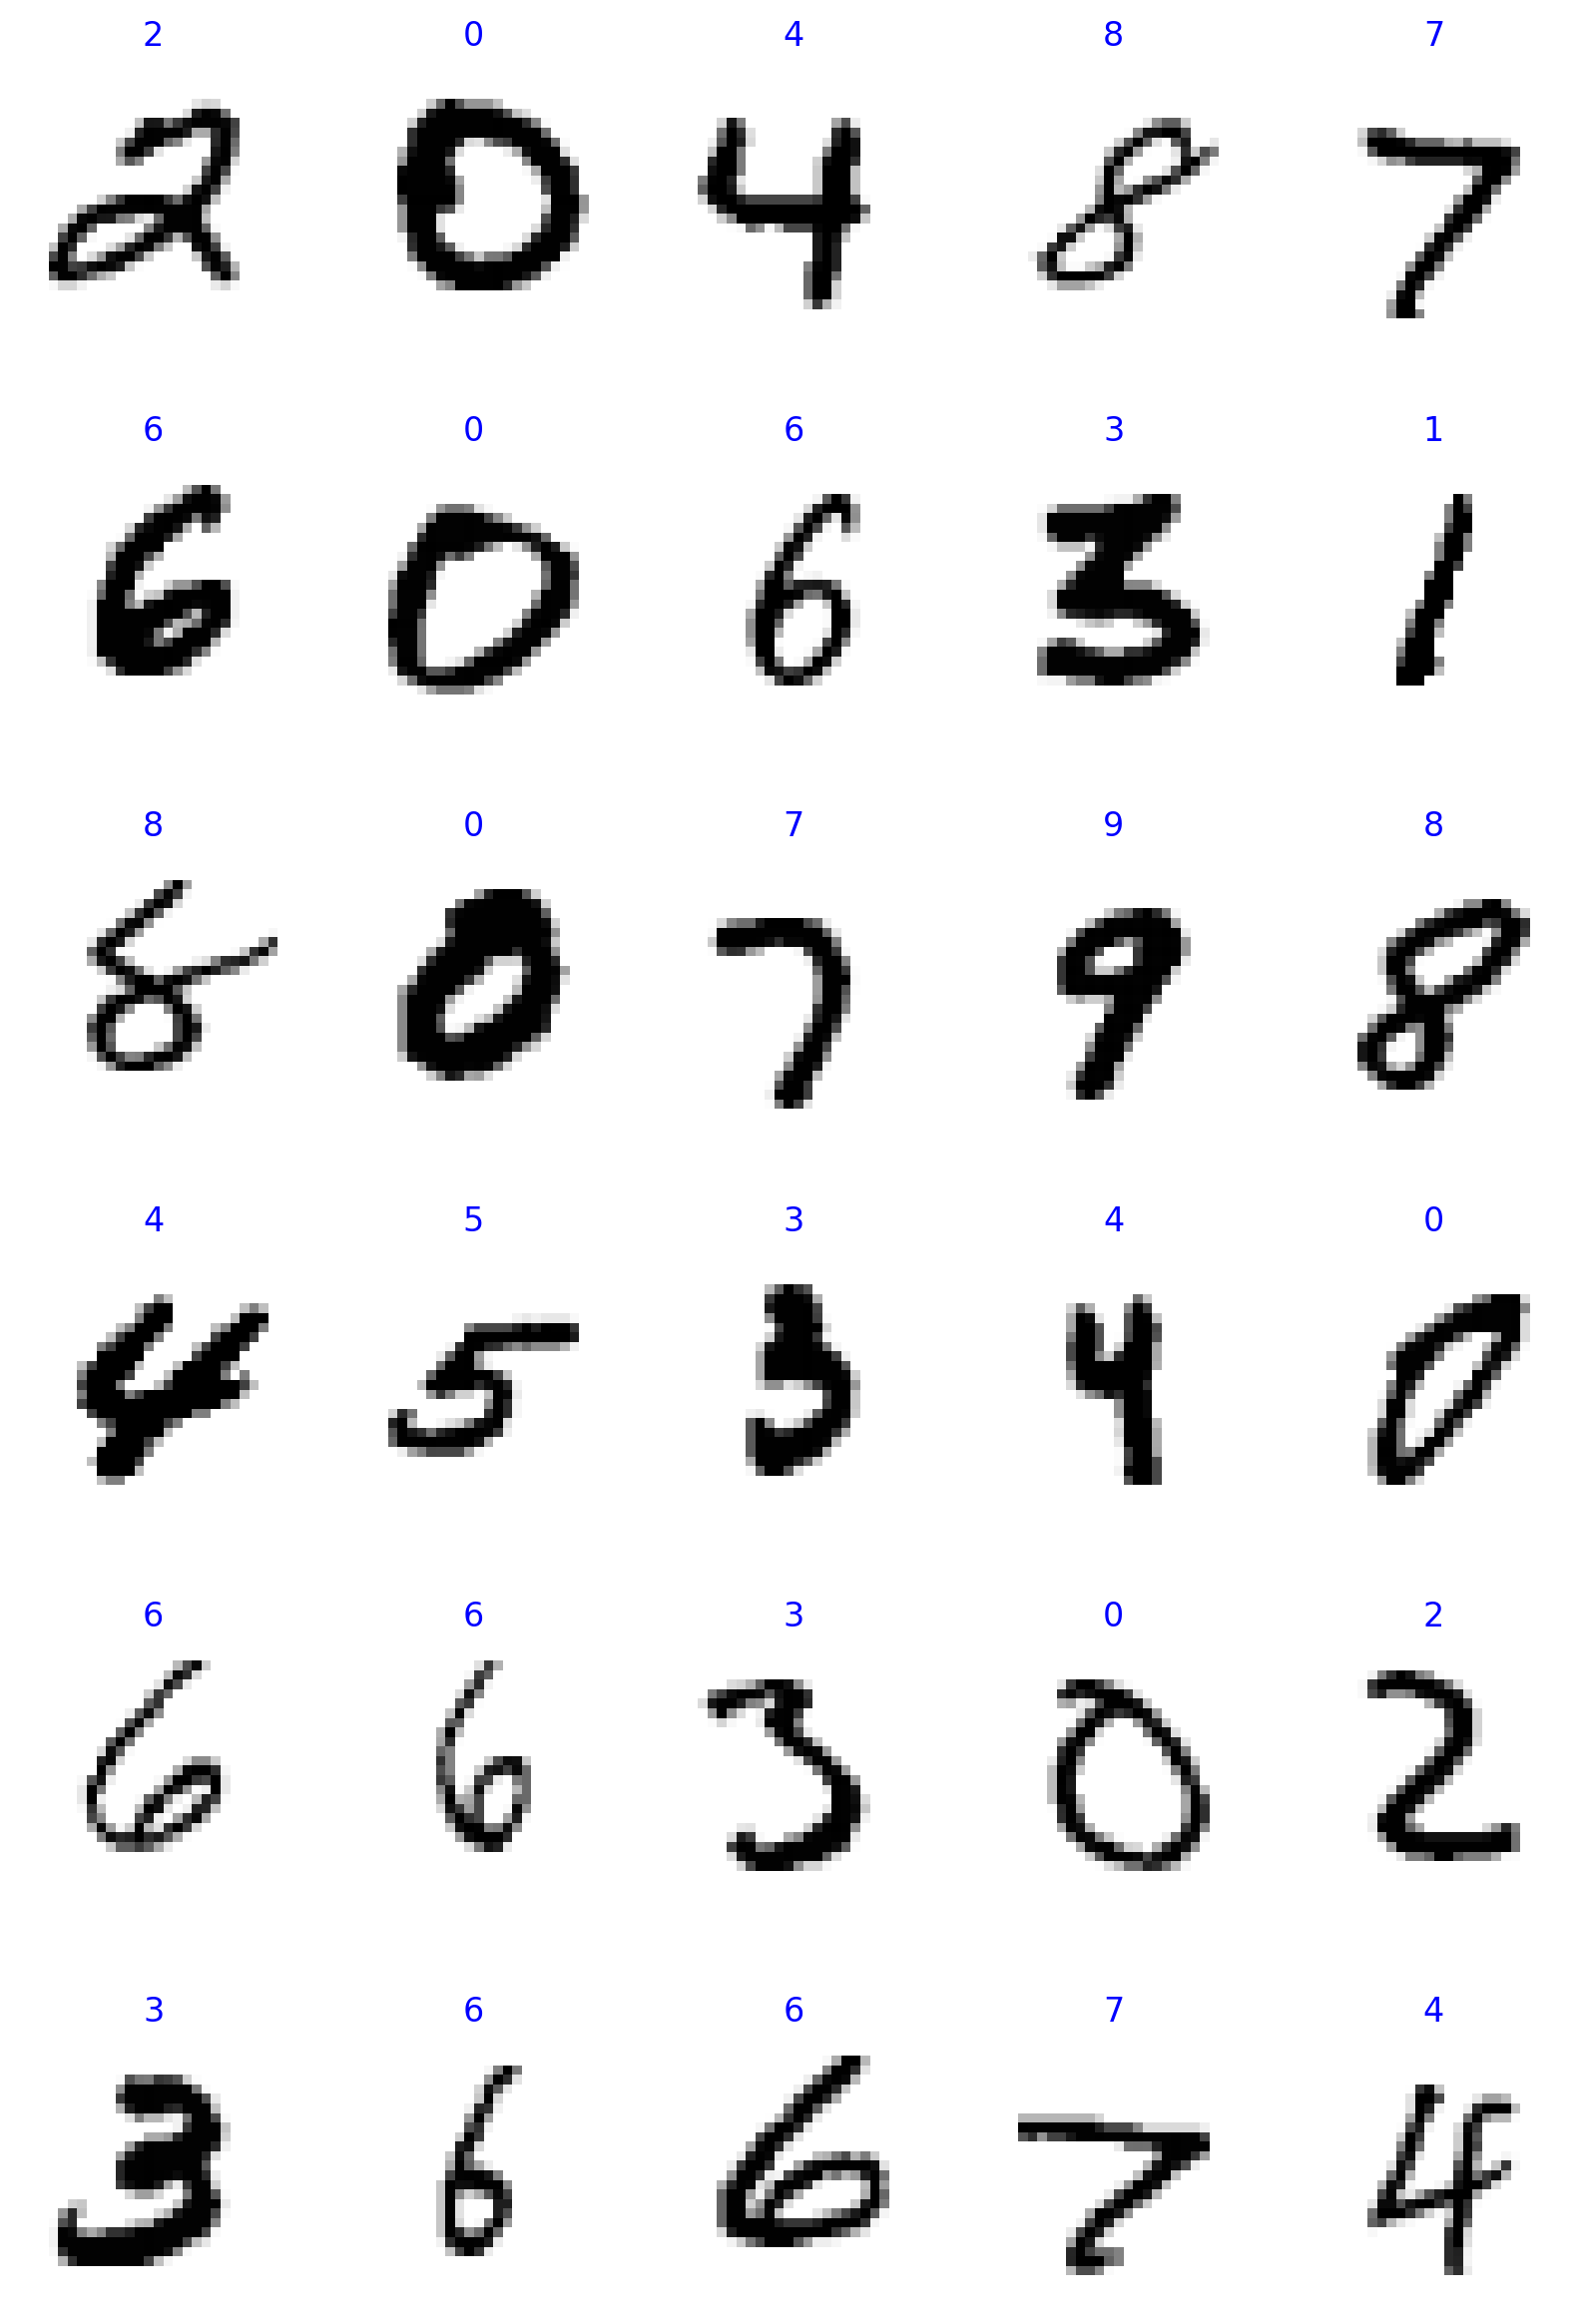

In [5]:
for image_batch, label_batch in testing_batches.take(1):
    images = image_batch.numpy().squeeze()
    labels = label_batch.numpy()

plt.figure(figsize=(10,15))

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(images[n], cmap = plt.cm.binary)
    plt.title(labels[n], color='blue')
    plt.axis('off')

### Build the Neural Network

In [59]:
tf.keras.backend.clear_session()
rate = 0.2
#units = 128
#units2 = 64
units = 480
units2 = 224
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (image_size, image_size, 1)),
        tf.keras.layers.Dense(units, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(units2, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

In [52]:
def model_builder(hp):
    hp_hidden_units0 = hp.Int('hidden_units0', min_value=64, max_value=512, step=32)
    hp_hidden_units1 = hp.Int('hidden_units1', min_value=64, max_value=512, step=32)
    rate = 0.2
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (image_size, image_size, 1)),
        tf.keras.layers.Dense(units=hp_hidden_units0, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(units=hp_hidden_units1, activation = 'relu'),
        tf.keras.layers.Dropout(rate),
        tf.keras.layers.Dense(10, activation = 'softmax')
    ])
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [55]:
import keras_tuner as kt
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

Reloading Tuner from my_dir/intro_to_kt/tuner0.json


In [56]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(training_batches, epochs=50, callbacks=[stop_early], validation_data=testing_batches)

Trial 30 Complete [00h 00m 52s]
val_accuracy: 0.982300877571106

Best val_accuracy So Far: 0.991150438785553
Total elapsed time: 00h 11m 49s


In [58]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
units = {best_hps.get('hidden_units0')}.
units2 = {best_hps.get('hidden_units1')}
""")


The hyperparameter search is complete. 
units = 480.
units2 = 224



### Configure the model

In [60]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
              

### Loss/Accuracy before training

In [61]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print(f'\nLoss before training: {loss:,.3f}')
print(f'Accuracy before training: {accuracy:.3%}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0417 - loss: 2.3643 

Loss before training: 2.362
Accuracy before training: 4.688%


### Train the Neural Network

In [62]:
EPOCHS = 100
PATIENCE = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE)
save_best = tf.keras.callbacks.ModelCheckpoint('./best_model.keras',
                                               monitor='val_loss',
                                               save_best_only=True)
history = model.fit(training_batches, epochs = EPOCHS, callbacks=[early_stopping, save_best], validation_data=testing_batches)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.8736 - loss: 0.4189 - val_accuracy: 0.9558 - val_loss: 0.1159
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9659 - loss: 0.1112 - val_accuracy: 0.9735 - val_loss: 0.0844
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9744 - loss: 0.0819 - val_accuracy: 0.9912 - val_loss: 0.0461
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9805 - loss: 0.0627 - val_accuracy: 0.9735 - val_loss: 0.0606
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9822 - loss: 0.0552 - val_accuracy: 0.9735 - val_loss: 0.0603
Epoch 6/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9854 - loss: 0.0455 - val_accuracy: 0.9735 - val_loss: 0.0442
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9869 - loss: 0.0407 - val_accuracy: 0.9735 - val_loss: 0.0792
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9885 - loss: 0.0369 - val_accu

### Model Training Performance

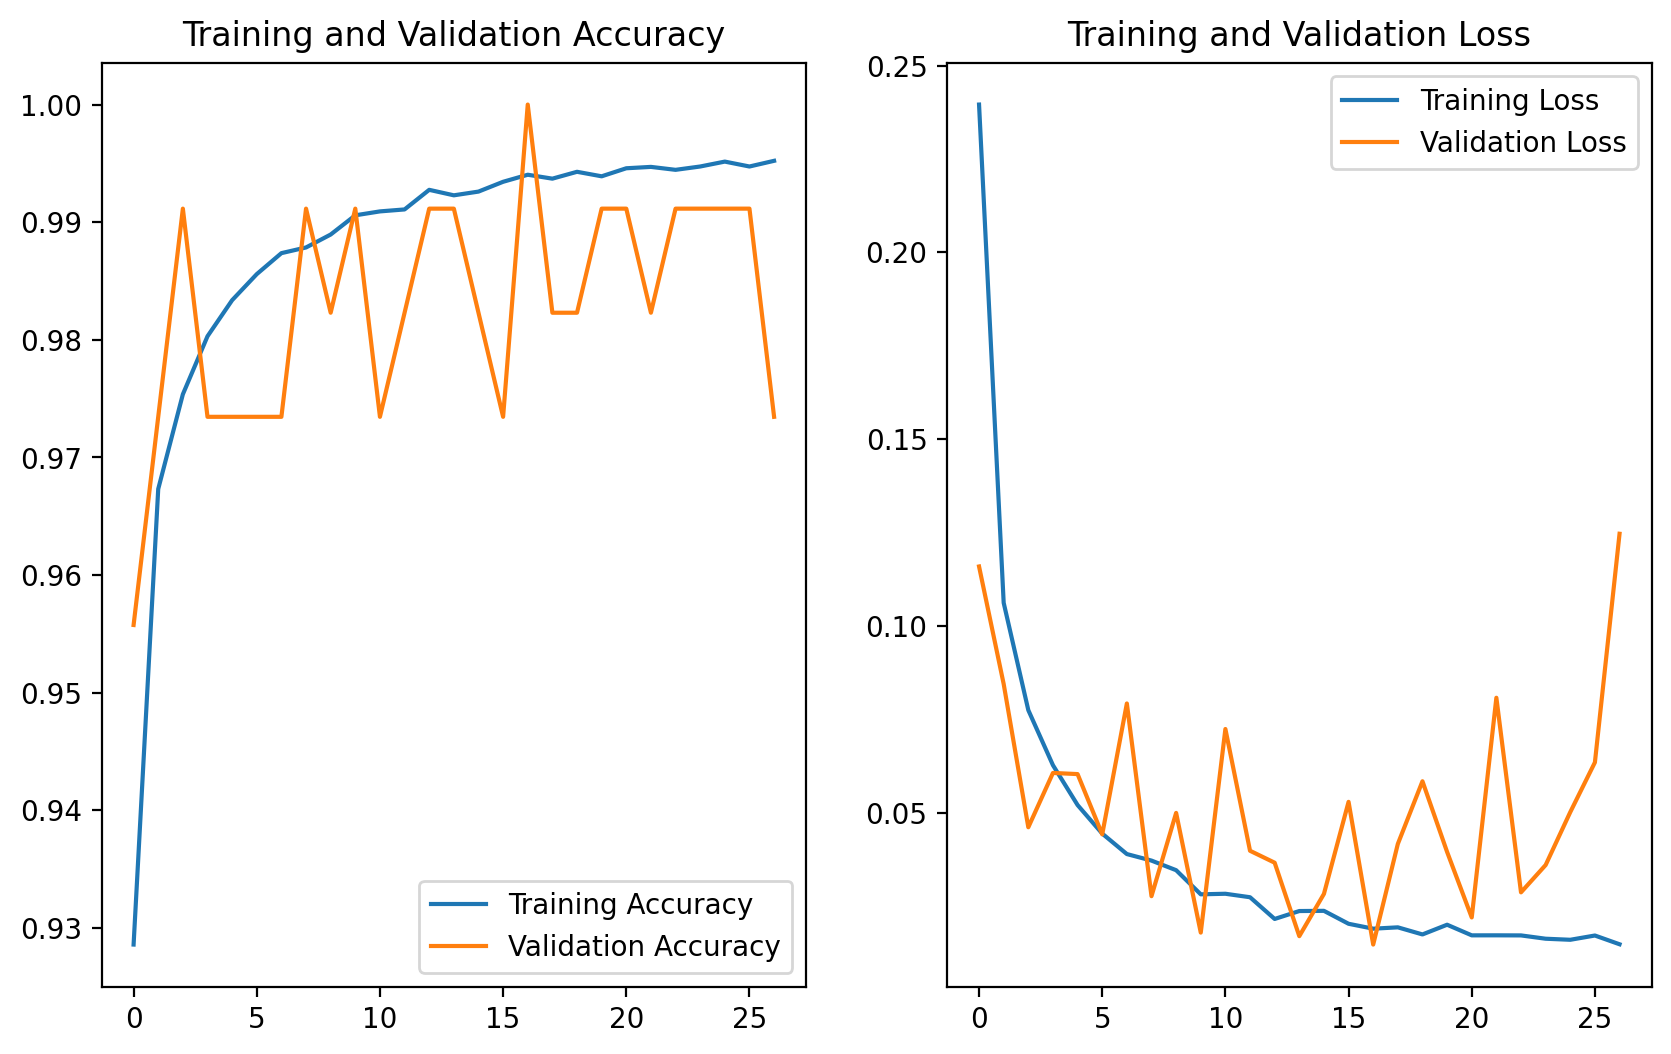

In [63]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs_range=range(len(training_accuracy))

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Loss/Accuracy after training

In [64]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print(f'\nLoss after training: {loss:,.3f}')
print(f'Accuracy after training: {accuracy:.3%}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 1.0000 - loss: 6.8880e-06

Loss after training: 0.000
Accuracy after training: 100.000%


In [65]:
loss, accuracy = model.evaluate(testing_batches)

print(f'\nLoss on the TEST Set: {loss:,.3f}')
print(f'Accuracy on the TEST Set: {accuracy:.3%}')

  1/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9688 - loss: 0.1813

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 56us/step - accuracy: 0.9734 - loss: 0.1250

Loss on the TEST Set: 0.125
Accuracy on the TEST Set: 97.345%


### Prediction

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


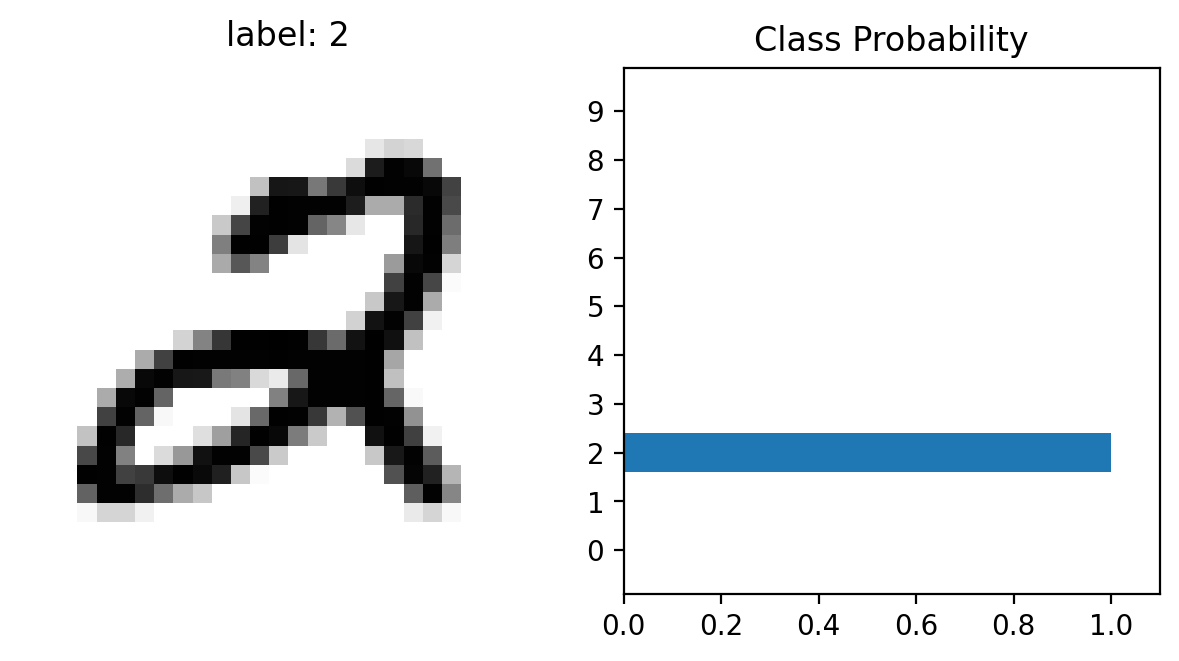

In [70]:
for image_batch, label_batch in testing_batches.take(1):
    ps = model.predict(image_batch)
    first_image = image_batch.numpy().squeeze()[0]
    label = label_batch.numpy()[0]
  
  
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.set_title(f'label: {label}')
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()